# Optimized Outcomes


This section of the notebook calculates the optimal outcome for ecosystem services produced by fallowed land to meet SGMA targets by ranking parcels within each crop type by a weighted average ecosystem services metric and selecting the top ranked parcels by crop type to meet fallowing targets set by the [PPIC.](https://www.ppic.org/publication/water-and-the-future-of-the-san-joaquin-valley/) 

Weights may be adjusted before running the notebook. By default, all ecosystem services are equally weighted.

In [1]:
# User-specified inputs
region_code = 'SW'

# Path to output, use as input to future notebooks
out_name = f'../outputs/optimal_{region_code}.csv'

In [2]:
import pandas as pd
import numpy as np
import geopandas as gd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx

In [3]:
# Inputs
fields = gd.read_file('../outputs/fields_shape.shp')
trials = pd.read_csv(f'../outputs/trials_{region_code}.csv')
targets = pd.read_csv('../data/targets.csv', index_col='region', thousands=',')

In [4]:
df = fields[fields['PPIC_Regio']==region_code].dropna(axis=0)

In [5]:
targets

,alfalfa-pasture,corn,field-crops-grains,veg-fruits,trees-vines
region,,,,,
NW,21320.0,8400.0,85920.0,3880.0,3880.0
NE,56850.0,7750.0,23580.0,2260.0,16800.0
SW,36820.0,3880.0,72350.0,8400.0,7750.0
SE,38760.0,16150.0,124030.0,650.0,9690.0
KR,88500.0,54910.0,42640.0,3230.0,11630.0


In [6]:
eco_services = ['SavedWat_1', 'TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD']
crop_types = targets.columns

In [7]:
# Create weights table with equal weights
# weight_vals = [1/len(eco_services)] * len(eco_services)
# out = OrderedDict(list(zip(eco_services, weight_vals)))
# out_df = pd.DataFrame(weight_vals, index = eco_services, columns = ['weights'])
# out_df.to_csv('../data/weights.csv')

In [8]:
weight_table = pd.read_csv('../data/weights.csv', index_col=0)
weight_table

,weights
SavedWat_1,0.166667
TNC,0.166667
Krat,0.166667
Kitfox,0.166667
Corridors,0.166667
CPAD,0.166667


In [9]:
weights = np.array(weight_table['weights'])
weights

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [10]:
weights.shape[0] == df[eco_services].shape[1]

True

In [11]:
weight_table.index.values == df[eco_services].columns.values

array([ True,  True,  True,  True,  True,  True])

In [12]:
df['outcome'] = np.average(df[eco_services], weights=weights, axis=1)
df['outcome'].isna().sum()

0

In [13]:
df.columns

Index(['Crop2014', 'Acres', 'FID', 'County', 'PPIC_Regio', 'Crop_PPIC',
       'Price', 'Rotations', 'AdjustedPr', 'FieldCropP', 'WaterConsu',
       'SavedWater', 'SavedWat_1', 'TNC', 'Krat', 'Kitfox', 'Corridors',
       'CPAD', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot', 'Corridors_',
       'CPAD_Total', 'geometry', 'outcome'],
      dtype='object')

In [14]:
#Get list of columns to track for each repetition
outcome_cols = ['Acres', 'FieldCropP', 'SavedWat_1', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot', 'Corridors_',
                'CPAD_Total', 'outcome'] 

In [15]:
df_optimal = pd.DataFrame(columns=df.columns)
for crop in crop_types:
    df_crop = df[df['Crop_PPIC'] == crop]
    target = targets.loc[region_code, crop]
    df_crop_sorted = df_crop.sort_values(['AdjustedPr','outcome'], ascending=[True,False])
    # Identify fields up to target
    df_fallow_bool = df_crop_sorted['Acres'].cumsum() < target
    # Get one additional field by updating value from False to True where 
    # first instance of False is located
    if not df_fallow_bool[df_fallow_bool!=True].empty:
        index = df_fallow_bool[df_fallow_bool!=True].index[0]
        df_fallow_bool.at[index]=True        
    df_crop_fallow = df_crop_sorted[df_fallow_bool]
    df_optimal = df_optimal.append(df_crop_fallow, ignore_index=True)
outcomes = pd.DataFrame(df_optimal[outcome_cols].sum()).T
areas = df_optimal[['Acres','Crop_PPIC']].groupby('Crop_PPIC').sum().T
areas.reset_index(drop=True, inplace=True)
output = pd.concat([outcomes, areas], axis=1, sort=False)

In [16]:
df_optimal.head(10)

,Crop2014,Acres,FID,County,PPIC_Regio,Crop_PPIC,Price,Rotations,AdjustedPr,FieldCropP,...,Kitfox,Corridors,CPAD,TNC_Total,Krat_Total,Kitfox_Tot,Corridors_,CPAD_Total,geometry,outcome
0,Mixed Pasture,14.890441,5224,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,280.12,...,0.000000,224.207871,0.000000,34.776605,0.000000,0.000000,33.385540,0.000000,POLYGON Z ((-13338873.00813901 4352036.2947104...,76.845634
1,Mixed Pasture,9.306203,4027,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,175.07,...,95.448832,0.000000,111.484236,0.000000,4.761107,8.882662,0.000000,10.374949,POLYGON Z ((-13326214.89180711 4337752.2127787...,43.361021
2,Mixed Pasture,56.272170,3870,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,1058.60,...,80.063456,0.000000,151.063124,0.000000,0.000000,45.053444,0.000000,85.006497,POLYGON Z ((-13345406.752445 4326741.018426451...,40.609772
3,Mixed Pasture,5.566964,4404,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,104.73,...,51.547337,0.000000,56.029714,1.466002,2.401749,2.869622,0.000000,3.119154,POLYGON Z ((-13327267.08150517 4336431.6269769...,29.715615
4,Mixed Pasture,34.353959,19120,Fresno,SW,alfalfa-pasture,15.917905,1.181818,18.812069,646.27,...,15.106016,33.568925,33.568925,11.532255,0.345968,5.189515,11.532255,11.532255,POLYGON Z ((-13396064.15272469 4402192.9412711...,20.747051
5,Mixed Pasture,2.453372,532,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,46.15,...,41.261734,0.000000,77.852329,0.000000,0.000000,1.012304,0.000000,1.910007,POLYGON Z ((-13337755.77475623 4350033.3526555...,19.943417
6,Mixed Pasture,1.842579,1698,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,34.66,...,34.273611,0.000000,37.253925,0.274573,0.528553,0.631518,0.000000,0.686433,POLYGON Z ((-13327276.04987397 4347713.2605295...,19.254175
7,Mixed Pasture,1.535491,420,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,28.89,...,0.518689,51.868854,0.000000,0.788477,0.003982,0.007964,0.796441,0.000000,POLYGON Z ((-13325472.74069794 4355844.6336144...,17.389871
8,Mixed Pasture,9.932567,8199,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,186.85,...,2.937013,39.160174,39.160174,0.000000,0.058344,0.291721,3.889611,3.889611,POLYGON Z ((-13345552.73970786 4352579.2817373...,14.009430
9,Mixed Pasture,4.118844,2105,Kings,SW,alfalfa-pasture,15.917905,1.181818,18.812069,77.48,...,2.849610,0.000000,0.000000,3.169017,0.064021,0.117371,0.000000,0.000000,POLYGON Z ((-13331824.73024866 4336625.5926753...,13.710076


In [17]:
df_optimal.to_csv(out_name)
df_optimal.columns

Index(['Crop2014', 'Acres', 'FID', 'County', 'PPIC_Regio', 'Crop_PPIC',
       'Price', 'Rotations', 'AdjustedPr', 'FieldCropP', 'WaterConsu',
       'SavedWater', 'SavedWat_1', 'TNC', 'Krat', 'Kitfox', 'Corridors',
       'CPAD', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot', 'Corridors_',
       'CPAD_Total', 'geometry', 'outcome'],
      dtype='object')

C:\Users\Erik\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


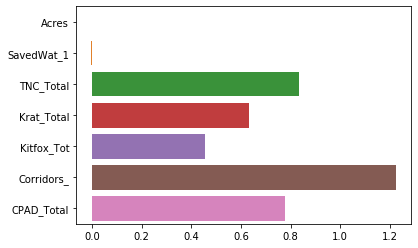

In [18]:
plot_cols = ['Acres', 'SavedWat_1', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot', 'Corridors_',
            'CPAD_Total']  #Exclude FieldCropPrice and optimal
optimal = df_optimal[plot_cols].sum()
as_usual = trials[plot_cols].mean()
pct_chg = (optimal - as_usual)/as_usual
sns.barplot(x = pct_chg, y = df_optimal[plot_cols].columns)

In [19]:
optimal_cost = df_optimal['FieldCropP'].sum()
print(f'${optimal_cost.sum():,.2f}')

$216,158,689.45


In [20]:
average_cost = trials['FieldCropP'].mean()
print(f'${average_cost:,.2f}')

$215,769,013.51


In [21]:
cost = df_optimal['FieldCropP'].sum() - trials['FieldCropP'].mean()
print (f'The cost of this optimization is ${cost:,.0f}')

The cost of this optimization is $389,676


In [22]:
for crop in crop_types:
    area_diff = df_optimal[df_optimal['Crop_PPIC']==crop]['Acres'].sum() - trials[crop].mean()
    print (f'{area_diff:,.2f} acres of {crop}')

71.96 acres of alfalfa-pasture
33.57 acres of corn
-36.97 acres of field-crops-grains
20.22 acres of veg-fruits
43.22 acres of trees-vines


In [23]:
df.columns

Index(['Crop2014', 'Acres', 'FID', 'County', 'PPIC_Regio', 'Crop_PPIC',
       'Price', 'Rotations', 'AdjustedPr', 'FieldCropP', 'WaterConsu',
       'SavedWater', 'SavedWat_1', 'TNC', 'Krat', 'Kitfox', 'Corridors',
       'CPAD', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot', 'Corridors_',
       'CPAD_Total', 'geometry', 'outcome'],
      dtype='object')

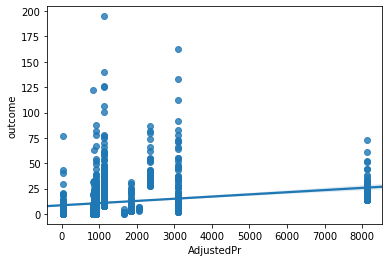

In [24]:
sns.regplot(y=df_optimal['outcome'], x=df_optimal['AdjustedPr'])

C:\Users\Erik\Anaconda3\lib\site-packages\seaborn\distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


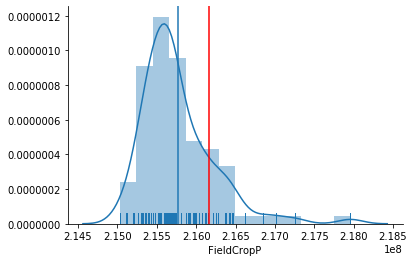

In [25]:
sns.distplot(trials['FieldCropP'], rug=True)
plt.axvline(x = df_optimal['FieldCropP'].sum(), color='red')
plt.axvline(x = trials['FieldCropP'].mean())
sns.despine()

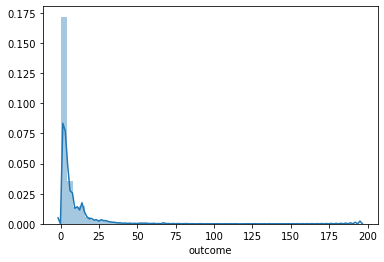

In [26]:
sns.distplot(df.dropna(subset=['outcome'])['outcome'])

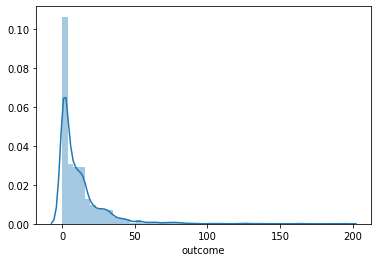

In [27]:
sns.distplot(df_optimal.dropna(subset=['outcome'])['outcome'])

In [28]:
sub_crops = df['Crop2014'].unique()
sub_crops

array(['Almonds', 'Grapes', 'Walnuts', 'Cotton', 'Pistachios',
       'Pomegranates', 'Tomatoes', 'Corn, Sorghum and Sudan',
       'Alfalfa and Alfalfa Mixtures', 'Melons, Squash and Cucumbers',
       'Miscellaneous Grasses', 'Peaches/Nectarines',
       'Miscellaneous Grain and Hay', 'Carrots',
       'Plums, Prunes and Apricots', 'Cherries',
       'Miscellaneous Truck Crops', 'Onions and Garlic',
       'Young Perennials', 'Lettuce/Leafy Greens', 'Citrus', 'Wheat',
       'Pears', 'Cole Crops', 'Mixed Pasture', 'Miscellaneous Deciduous',
       'Bush Berries', 'Olives', 'Apples', 'Peppers', 'Safflower',
       'Kiwis', 'Flowers, Nursery and Christmas Tree Farms',
       'Beans (Dry)', 'Strawberries', 'Miscellaneous Subtropical Fruits'],
      dtype=object)

In [29]:
len(sub_crops)

36

In [30]:
data = df_optimal[df_optimal['Crop2014']=='Alfalfa and Alfalfa Mixtures']
x = data['FieldCropP']
y = data['outcome']

In [31]:
df_by_crop = df_optimal.groupby(['Crop2014']).mean()
df_by_crop

,Acres,Price,Rotations,AdjustedPr,FieldCropP,WaterConsu,SavedWater,SavedWat_1,TNC,Krat,Kitfox,Corridors,CPAD,TNC_Total,Krat_Total,Kitfox_Tot,Corridors_,CPAD_Total,outcome
Crop2014,,,,,,,,,,,,,,,,,,,
Alfalfa and Alfalfa Mixtures,82.355894,1113.653444,1.000000,1113.653444,91715.925564,4.692884,388.087549,18.392513,9.989020,2.898631,15.083798,29.855946,44.231098,5.885219,1.538180,10.498168,21.965803,37.688816,20.075168
Apples,29.913272,1657.747573,1.000000,1657.747573,49588.654667,3.833797,114.386667,5.421092,0.000000,0.000000,0.810928,1.792694,0.000000,0.000000,0.000000,0.205759,0.173473,0.000000,1.337452
Beans (Dry),171.963417,1060.225352,1.935484,2052.049069,352877.370000,2.784316,478.802000,22.691715,3.045000,0.223163,4.616482,0.000000,0.000000,4.792436,0.393769,4.795803,0.000000,0.000000,5.096060
"Corn, Sorghum and Sudan",80.640247,1061.698113,2.222222,2359.329140,190256.884490,2.871760,228.813469,10.844086,34.847553,11.112921,29.409157,95.352725,65.311341,20.189722,3.811529,13.078136,86.935815,64.569280,41.146297
Miscellaneous Grain and Hay,85.856051,493.250000,1.740741,858.620370,73717.754679,1.395178,119.160550,5.647339,3.401914,0.786485,3.298546,4.925726,14.383300,2.815808,1.157377,2.686031,4.459281,20.435107,5.407219
Miscellaneous Grasses,36.387433,347.114537,2.352941,816.740088,29719.075946,4.700062,170.995676,8.103945,0.000000,4.874102,12.197621,1.858708,16.498843,0.000000,1.772092,4.464857,1.699316,1.808400,7.255536
Mixed Pasture,9.848431,15.917905,1.181818,18.812069,185.269257,4.700874,46.298366,2.194204,3.728547,0.731402,3.938464,3.191613,4.874210,0.560076,0.047719,0.496396,0.307698,0.779252,3.109740
Safflower,232.065131,1061.698113,1.729730,1836.450790,426176.193457,2.375114,553.211728,26.218193,1.205107,1.311919,8.187449,5.815597,5.395465,2.865865,3.470178,17.983775,8.484920,9.028447,8.022288
Tomatoes,89.540301,4232.650066,1.920354,8128.186409,727800.257625,2.304236,203.083750,9.624685,9.359055,2.721104,9.705431,38.333713,63.052787,7.421660,1.854252,8.384085,30.923861,58.017619,22.132796


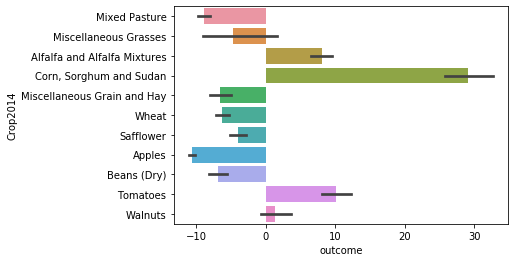

In [32]:
crop_mean_outcome = df_optimal['outcome'].mean()
sns.barplot(data=df_optimal, x='outcome', y='Crop2014', estimator = (lambda x: np.mean(x)-crop_mean_outcome), ci=90)

# Mapping

In [33]:
fields_to_map = fields[fields['PPIC_Regio']==region_code].set_index('FID').join(df_optimal.set_index('FID'), how='inner', lsuffix = 'l')
# Alternative from geopandas (have to create new (or could rename) 'FID_1' to 'FID' to have matching column) 
#fields['FID'] = fields['FID_1']
#fields_to_map = fields.merge(df_optimal, on='FID')

In [34]:
plt.rcParams["figure.figsize"] = (20,10)
xlim = ([fields_to_map.geometry.total_bounds[0], fields_to_map.geometry.total_bounds[2]])
ylim = ([fields_to_map.geometry.total_bounds[1], fields_to_map.geometry.total_bounds[3]])

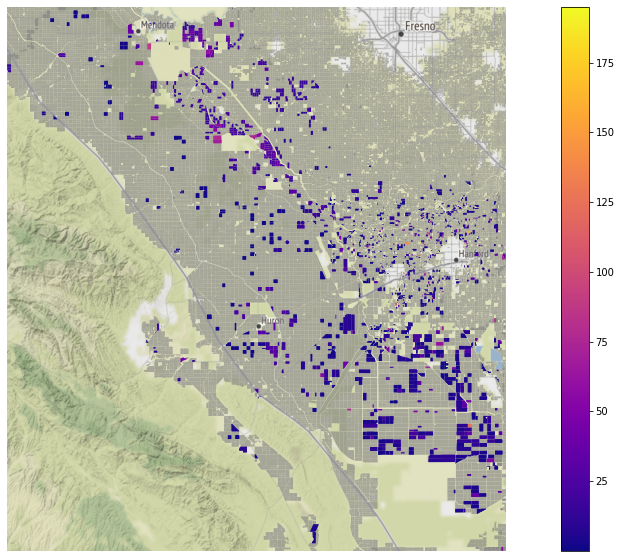

In [35]:
base = fields.plot(color='grey', alpha=0.6)
fields_to_map.plot(ax=base, column='outcome', cmap='plasma', legend=True)
base.set_xlim(xlim)
base.set_ylim(ylim)
ctx.add_basemap(base, url=ctx.sources.ST_TERRAIN, reset_extent=True)
base.set_axis_off()